# retrain pSMF
For some reason pSMF sometimes does not train well. 

In [1]:
import os
import h5py 
import numpy as np
from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13

In [2]:
import copy
import torch
from torch import nn
from torch import optim
import torch.distributions as D

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/tigress/chhahn/provabgs/svda'

In [5]:
if torch.cuda.is_available(): 
    device = torch.device(type='cuda', index=0)
else: 
    device = 'cpu'

# set targets and $z$ range

In [6]:
targ = 'bgs_bright'
zmin = 0.17
zmax = 0.21
jack = None

# compile $M_*$ posteriors

In [7]:
bgs = aTable.Table.read(os.path.join(dat_dir, 'BGS_ANY_full.provabgs.lite.hdf5'))

In [8]:
if targ == 'bgs_bright':
    bgs = bgs[bgs['is_bgs_bright']]
elif targ =='bgs_faint':
    bgs = bgs[bgs['is_bgs_faint']]
elif targ == 'bgs_any':
    pass
elif targ == 'bgs_bright_q':
    is_quiescent = ((np.log10(np.median(bgs['provabgs_avgSFR1Gyr_mcmc'].data, axis=1)) - np.median(bgs['provabgs_logMstar'].data, axis=1)) < -11.2)
    bgs = bgs[bgs['is_bgs_bright'] & is_quiescent]
elif targ == 'bgs_bright_sf':
    is_quiescent = ((np.log10(np.median(bgs['provabgs_avgSFR1Gyr_mcmc'].data, axis=1)) - np.median(bgs['provabgs_logMstar'].data, axis=1)) < -11.2)
    bgs = bgs[bgs['is_bgs_bright'] & ~is_quiescent]

# redshift limit
zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & (bgs['provabgs_w_zfail'].data > 0)
bgs = bgs[zlim]

In [9]:
fields = [
    ((bgs['RA'] > 140) & (bgs['RA'] < 160)),
    ((bgs['RA'] > 160) & (bgs['RA'] < 185) & (bgs['DEC'] > -10) & (bgs['DEC'] < 10)),
    ((bgs['RA'] > 205) & (bgs['RA'] < 212) & (bgs['DEC'] > 2) & (bgs['DEC'] < 8)),
    ((bgs['RA'] > 210) & (bgs['RA'] < 224) & (bgs['DEC'] > -5) & (bgs['DEC'] < 5) & ~((bgs['RA'] > 205) & (bgs['RA'] < 212) & (bgs['DEC'] > 2) & (bgs['DEC'] < 8))),
    ((bgs['RA'] > 190) & (bgs['RA'] < 200) & (bgs['DEC'] > 20) & (bgs['DEC'] < 30)),
    ((bgs['RA'] > 210) & (bgs['RA'] < 225) & (bgs['DEC'] > 30) & (bgs['DEC'] < 40)),
    ((bgs['RA'] > 250) & (bgs['RA'] < 260) & (bgs['DEC'] > 30) & (bgs['DEC'] < 40)),
    ((bgs['RA'] > 230) & (bgs['RA'] < 255) & (bgs['DEC'] > 40) & (bgs['DEC'] < 45)),
    ((bgs['RA'] > 210) & (bgs['RA'] < 225) & (bgs['DEC'] > 45) & (bgs['DEC'] < 58)),
    ((bgs['RA'] > 235) & (bgs['RA'] < 255) & (bgs['DEC'] > 50) & (bgs['DEC'] < 60)),
    ((bgs['RA'] > 180) & (bgs['RA'] < 200) & (bgs['DEC'] > 55) & (bgs['DEC'] < 70)),
    ((bgs['RA'] > 260) & (bgs['RA'] < 280) & (bgs['DEC'] > 55) & (bgs['DEC'] < 70))
]

A_fields = [164.965, 156.064, 164.917, 138.785, 155.972, 164.848, 165.120, 148.024,
            165.015, 165.030, 164.890, 156.806]

if jack is None: 
    f_area = (173.641/(4.*np.pi*(180/np.pi)**2))
else: 
    bgs = bgs[~fields[jack]]
    f_area = (A_fields[jack]/(4.*np.pi*(180/np.pi)**2))

In [10]:
print('%i galaxies' % len(bgs))

19811 galaxies


# estimate $p(M_* | \{x_i, z_i \})$ in $z$ bins --- incorrectly

Lets just look at the median of the posteriors

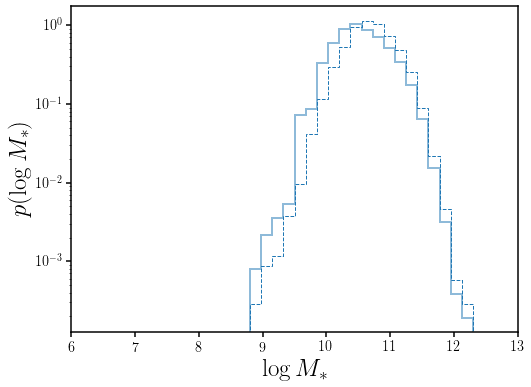

In [11]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area # (Mpc/h)^3

w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) 
w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign'].data

_ = sub.hist(np.median(bgs['provabgs_logMstar'].data, axis=1), 
             bins=40, range=(6., 13.), color='C0', 
             linestyle='--', histtype='step', density=True)
_ = sub.hist(np.median(bgs['provabgs_logMstar'].data, axis=1), 
             weights=w_import, bins=40, range=(6., 13.), 
             color='C0', linewidth=2, histtype='step', alpha=0.5, density=True)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(6., 13)
sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
sub.set_yscale('log')
plt.show()

# estimate $p(M_* | \{x_i, z_i \})$ in $z$ bins --- correctly

In [12]:
class GaussianMixtureModel(nn.Module):
    def __init__(self, n_components: int=2, mmin=7., mmax=13.):
        super().__init__()
        logweights = torch.zeros(n_components, )
        means   = (mmax-mmin)*torch.rand(n_components, ) + mmin
        logstdevs  = 0.1*torch.tensor(np.random.uniform(size=n_components)) - 1.
      
        #print(mmin, mmax)
        #print(torch.exp(logweights))
        #print(means)
        #print(torch.exp(logstdevs))
        self.logweights = torch.nn.Parameter(logweights)
        self.means   = torch.nn.Parameter(means)
        self.logstdevs  = torch.nn.Parameter(logstdevs)
    
    def forward(self, x):
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return - gmm.log_prob(x).mean()
    
    def log_prob(self, x): 
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        return gmm.log_prob(x)
    
    def sample(self, N):
        #print(torch.exp(self.logweights))
        #print(self.means)
        #print(torch.exp(self.logstdevs))
        mix  = D.Categorical(torch.exp(self.logweights))
        comp = D.Normal(self.means, torch.exp(self.logstdevs))
        gmm  = D.MixtureSameFamily(mix, comp)
        
        return gmm.sample(N)
    
    
def Loss(qphi, post, w): 
    ''' calculate loss
    
    \sum_i^Ng w_i * \log \sum_j^Ns qphi(\theta_ij)
    
    '''
    logqphi = qphi.log_prob(post.flatten()[:,None]).reshape(post.shape)

    return -torch.sum(w * torch.logsumexp(logqphi, axis=1))  

1.0 612.0132474339779
8.736540794372559 12.430063247680664
GMM with 72 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>104 	 -6.29307e+00


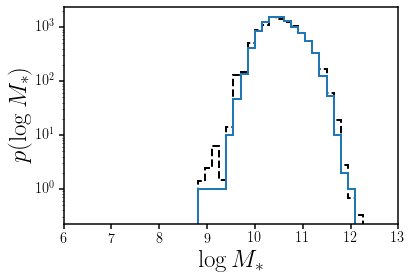

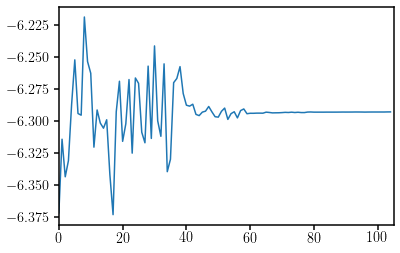

8.736540794372559 12.430063247680664
GMM with 87 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>84 	 -6.29117e+00


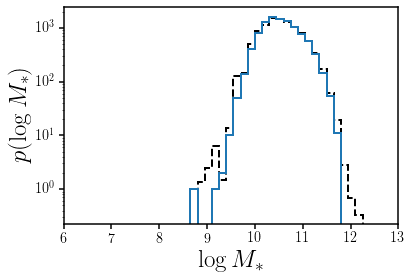

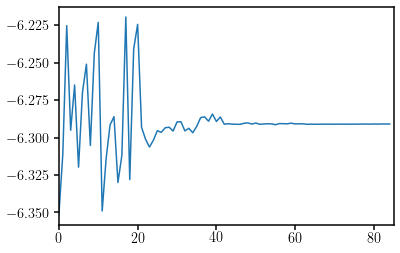

8.736540794372559 12.430063247680664
GMM with 6 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>99 	 -6.29720e+00


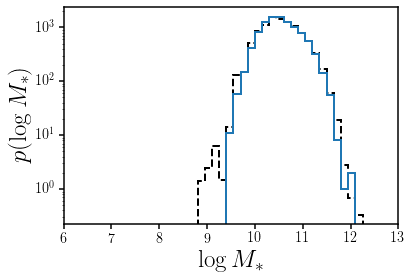

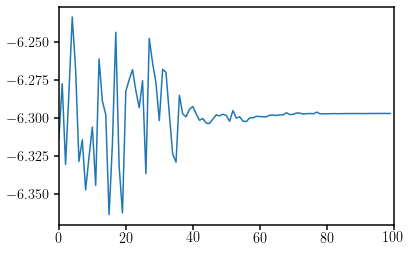

8.736540794372559 12.430063247680664
GMM with 92 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>224 	 -6.29097e+00


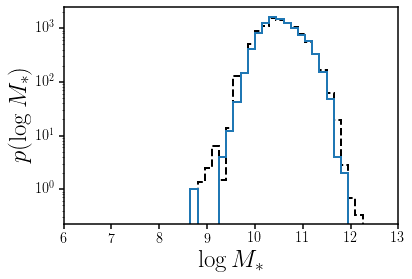

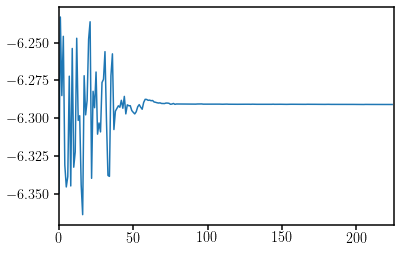

8.736540794372559 12.430063247680664
GMM with 79 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>102 	 -6.29044e+00


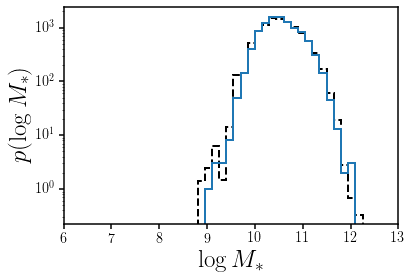

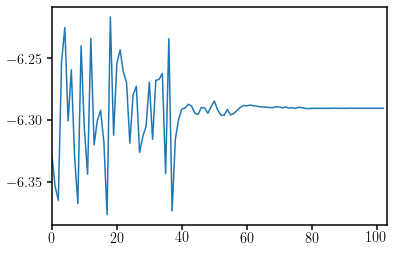

8.736540794372559 12.430063247680664
GMM with 95 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>149 	 -6.29395e+00


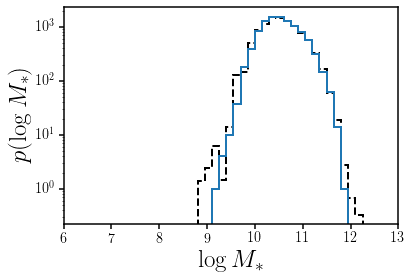

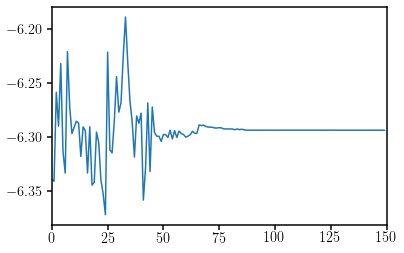

8.736540794372559 12.430063247680664
GMM with 22 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>87 	 -6.29135e+00


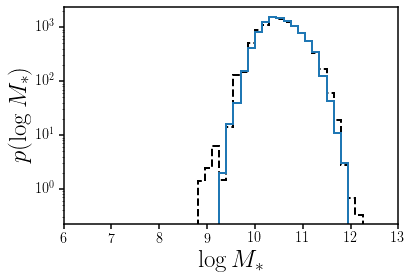

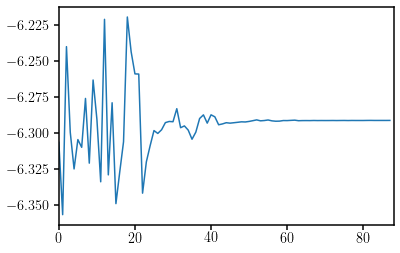

8.736540794372559 12.430063247680664
GMM with 6 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>132 	 -6.29968e+00


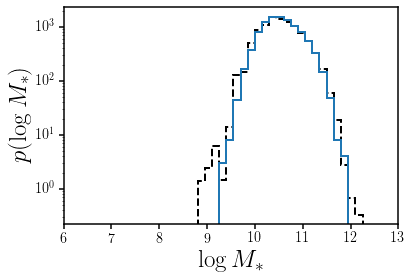

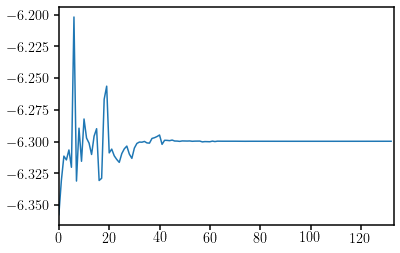

8.736540794372559 12.430063247680664
GMM with 30 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>84 	 -6.29327e+00


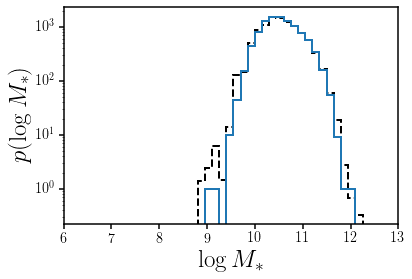

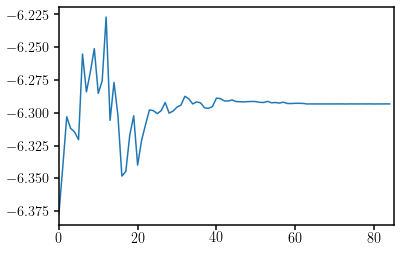

8.736540794372559 12.430063247680664
GMM with 82 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>169 	 -6.29214e+00


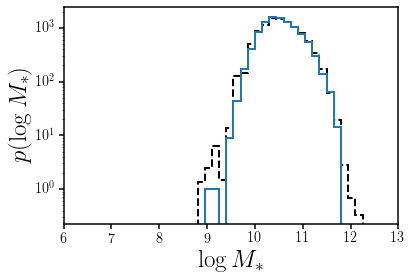

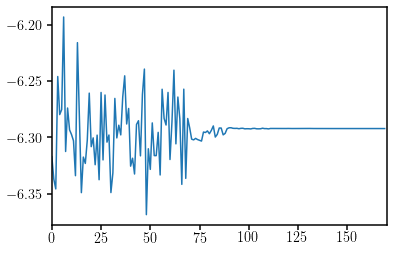

In [13]:
num_iter = 1000
patience = 20 
n_model = 10
lr = 1e-2

v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area # (Mpc/h)^3

w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) 
w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']
print(w_import.min(), w_import.max())

x_data = torch.tensor(bgs['provabgs_logMstar'].data.astype(np.float32)).to(device)
w_data = torch.tensor(w_import.astype(np.float32)).to(device)

# make sure there aren't any Nans
assert torch.sum(np.isnan(x_data.cpu())) == 0 
assert torch.sum(np.isnan(w_data.cpu())) == 0

batch_size = 128
Ntrain = int(0.9 * x_data.shape[0])
Nvalid = x_data.shape[0] - Ntrain # int(0.1 * x_data.shape[0])

trainloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_data[:Ntrain], w_data[:Ntrain]),
        batch_size=batch_size,
        shuffle=True)

validloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_data[Ntrain:], w_data[Ntrain:]),
        batch_size=batch_size)


best_flows, best_valid_losses, vls = [], [], []
for i in range(n_model): 
    ncomp = int(np.random.uniform(5, 100))
    flow = GaussianMixtureModel(n_components=ncomp, 
                                mmin=bgs['provabgs_logMstar'].data.min(), 
                                mmax=bgs['provabgs_logMstar'].data.max())

    print(bgs['provabgs_logMstar'].data.min(), bgs['provabgs_logMstar'].data.max())
    flow.to(device)
    print('GMM with %i components' % ncomp)


    best_valid_loss = np.inf
    valid_losses, lrs = [], []
    optimizer = optim.Adam(flow.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, min_lr=1e-5)

    best_epoch = 0 
    t = trange(num_iter, leave=False)
    for epoch in t:
        train_loss = 0.
        for batch in trainloader: 
            optimizer.zero_grad()
            _post, _w = batch
            _post = _post.to(device)
            _w = _w.to(device)

            loss = Loss(flow, _post, _w)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        train_loss /= len(trainloader.dataset)

        with torch.no_grad():
            valid_loss = 0.
            for batch in validloader: 
                _post, _w = batch
                _post = _post.to(device)
                _w = _w.to(device)

                loss = Loss(flow, _post, _w)                
                valid_loss += loss.item()
            valid_loss /= len(validloader.dataset)           
            valid_losses.append(valid_loss)

        scheduler.step(valid_loss)
        t.set_description('Epoch: %i LR %.2e TRAINING Loss: %.2e VALIDATION Loss: %.2e' % 
                          (epoch, scheduler._last_lr[0], train_loss, valid_loss), refresh=False)
        if scheduler._last_lr[0] == 1e-5: 
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                best_epoch = epoch
                best_flow = copy.deepcopy(flow)
            else: 
                if epoch > best_epoch + patience: 
                    break 

    print('>>>%i \t %.5e' % (epoch, best_valid_loss))

    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    _ = sub.hist(np.median(bgs['provabgs_logMstar'].data, axis=1), 
             weights=w_import*10000./np.sum(w_import), 
             range=(7., 13.), bins=40, histtype='step', 
             color='k', linestyle='--', linewidth=2)
    with torch.no_grad(): 
        post_prime = best_flow.sample((10000,))
    _ = sub.hist(np.array(post_prime.detach().cpu()), range=(7., 13.), bins=40, histtype='step', linewidth=2)
    sub.set_xlabel(r'$\log M_*$', fontsize=25)
    sub.set_xlim(6., 13.)
    sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
    sub.set_yscale('log')
    plt.show()

    plt.plot(np.arange(len(valid_losses)), valid_losses)
    plt.xlim(0, len(valid_losses))
    plt.show()

    best_flows.append(best_flow)
    best_valid_losses.append(best_valid_loss)
    vls.append(valid_losses)

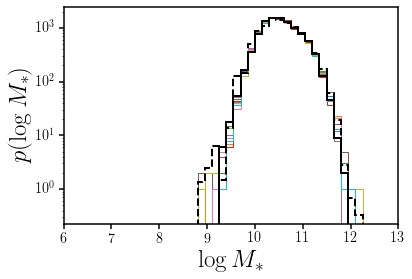

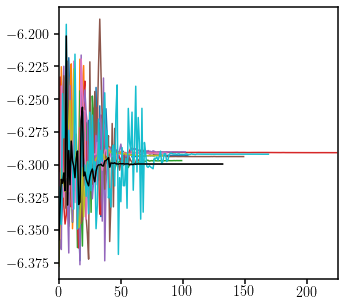

In [14]:
ibest = np.argmin(best_valid_losses)

fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)
for flow in best_flows: 
    with torch.no_grad():
        post_prime = flow.sample((10000,))
        _ = sub.hist(np.array(post_prime.detach().cpu()), range=(7., 13.), bins=40, 
                     histtype='step', linewidth=1)

with torch.no_grad():
    post_prime = best_flows[ibest].sample((10000,))
    _ = sub.hist(np.array(post_prime.detach().cpu()), range=(7., 13.), bins=40, 
                 histtype='step', linewidth=2, color='k')

_ = sub.hist(np.median(bgs['provabgs_logMstar'], axis=1),
        weights=w_import*10000./np.sum(w_import),
        range=(7., 13.), bins=40, histtype='step', color='k', linestyle='--', linewidth=2)

sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(6., 13.)
sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
sub.set_yscale('log')
if jack is None: 
    fig.savefig(os.path.join(dat_dir, 'psmf.gmm.%s.z%.2f_%.2f.png' % (targ, zmin, zmax)), bbox_inches='tight')
else: 
    fig.savefig(os.path.join(dat_dir, 'psmf.gmm.%s.z%.2f_%.2f.jack%i.png' % (targ, zmin, zmax, jack)), bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
for vl in vls:
    sub.plot(np.arange(len(vl)), vl)
sub.plot(np.arange(len(vls[ibest])), vls[ibest], c='k')
sub.set_xlim(0, np.max([len(vl) for vl in vls]))
if jack is None: 
    fig.savefig(os.path.join(dat_dir, 'psmf.gmm.%s.z%.2f_%.2f.loss.png' % (targ, zmin, zmax)), bbox_inches='tight')
else: 
    fig.savefig(os.path.join(dat_dir, 'psmf.gmm.%s.z%.2f_%.2f.jack%i.loss.png' % (targ, zmin, zmax, jack)), bbox_inches='tight')

In [15]:
if jack is None: 
    fgmm = os.path.join(dat_dir, 'psmf.gmm.%s.z%.2f_%.2f.pt' % (targ, zmin, zmax))
else: 
    fgmm = os.path.join(dat_dir, 'psmf.gmm.%s.z%.2f_%.2f.jack%i.pt' % (targ, zmin, zmax, jack))
torch.save(best_flows[ibest], fgmm)

28564 galaxies
1.0 612.0132474339779
8.481919288635254 12.430063247680664
GMM with 99 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>999 	 -6.21393e+00
tensor([2.9506, 0.9088, 0.8238, 1.3841, 0.4431, 1.2885, 0.8998, 2.1431, 0.7565,
        2.1423, 0.7600, 0.9391, 1.0248, 0.7957, 1.2679, 1.0727, 1.9438, 1.7976,
        1.9239, 0.5527, 0.5487, 1.8114, 1.1531, 0.7137, 0.5830, 2.5771, 1.4871,
        0.9705, 0.6942, 0.5277, 6.6893, 5.4837, 1.4872, 5.2308, 1.0174, 0.3161,
        1.6755, 1.0739, 0.5624, 0.5471, 0.5780, 2.4973, 0.9314, 0.3803, 1.4152,
        0.7116, 2.2656, 0.7736, 2.6577, 0.5440, 1.3630, 2.2656, 2.1769, 1.0137,
        2.7177, 0.9039, 0.5524, 0.5911, 1.0486, 0.5324, 0.5262, 0.5367, 6.7452,
        6.8530, 1.3797, 6.4938, 0.8174, 0.9795, 2.2330, 0.6639, 3.4687, 0.5130,
        3.3795, 2.1100, 0.8917, 0.9185, 0.7582, 0.5766, 0.8014, 0.4498, 6.0737,
        1.1479, 2.2867, 1.0535, 0.3361, 0.5201, 0.8218, 6.6996, 0.7490, 2.0393,
        6.8405, 0.5673, 6.6507, 0.5377, 1.6086, 2.0977, 1.4381, 0.5505, 0.7270],
       device='cuda:0', grad_fn=<ExpBackward0>)
Parameter containing:
tensor([10.2820, 10.9152, 1

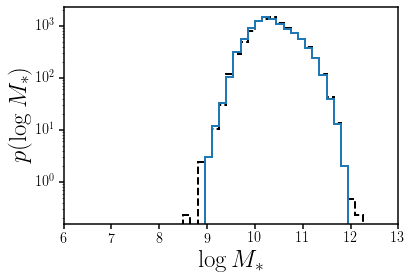

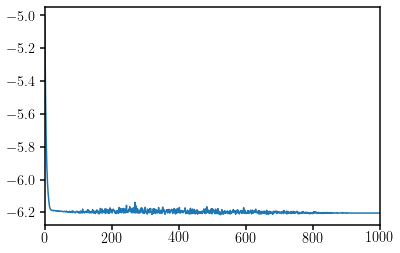

8.481919288635254 12.430063247680664
GMM with 13 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>999 	 -6.21084e+00
tensor([4.8326, 1.2507, 2.3395, 0.6372, 0.7484, 0.5102, 0.6082, 0.5949, 2.4018,
        0.5711, 1.0352, 0.5265, 0.8699], device='cuda:0',
       grad_fn=<ExpBackward0>)
Parameter containing:
tensor([10.2322, 10.2319, 10.2319, 10.9777, 10.9777, 10.3593, 10.2324, 10.2324,
        10.2319, 10.2325, 10.9777, 10.9777, 10.2319], device='cuda:0',
       requires_grad=True)
tensor([0.3487, 0.3485, 0.3485, 0.2570, 0.2570, 0.0366, 0.3488, 0.3488, 0.3485,
        0.3488, 0.2570, 0.2570, 0.3485], device='cuda:0', dtype=torch.float64,
       grad_fn=<ExpBackward0>)


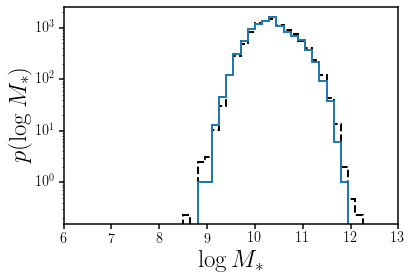

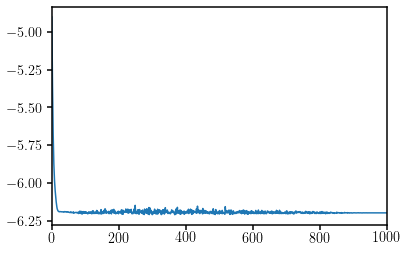

8.481919288635254 12.430063247680664
GMM with 95 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>999 	 -6.21552e+00
tensor([2.7533, 0.6067, 0.7142, 1.5055, 1.0578, 1.4193, 0.9562, 2.6203, 0.6820,
        0.6246, 1.2080, 2.6159, 0.5239, 0.5296, 0.4320, 0.4229, 1.4678, 0.3864,
        0.9423, 1.5434, 1.3347, 0.7524, 1.2170, 2.5518, 1.5904, 0.4119, 0.8333,
        0.6588, 1.2550, 0.5722, 0.8857, 0.7651, 0.5645, 2.5606, 1.4749, 0.8526,
        1.1666, 1.3675, 1.4536, 0.4181, 0.8931, 1.4774, 0.4197, 2.6471, 0.5042,
        0.8114, 0.6181, 0.6099, 1.4381, 0.4224, 0.7336, 0.7627, 0.4005, 1.5596,
        0.4717, 1.1784, 0.6974, 1.2101, 2.4065, 0.7629, 1.0446, 0.7864, 1.2024,
        1.0379, 0.5879, 0.9232, 0.3869, 1.2645, 1.3435, 0.4181, 1.1859, 0.6980,
        1.4403, 2.3267, 0.7016, 1.5660, 0.9665, 1.1847, 1.1594, 1.1879, 0.4038,
        1.0777, 1.1485, 1.3360, 0.5585, 0.6839, 1.8833, 0.6881, 0.7046, 0.5766,
        2.3753, 0.9520, 0.6033, 0.7331, 0.3762], device='cuda:0',
       grad_fn=<ExpBackward0>)
Parameter containing:
tensor([10.2283, 10.9526, 10.9526, 10.2262, 10.2256, 10.226

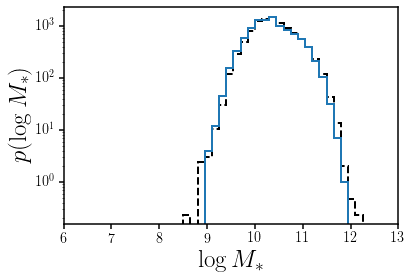

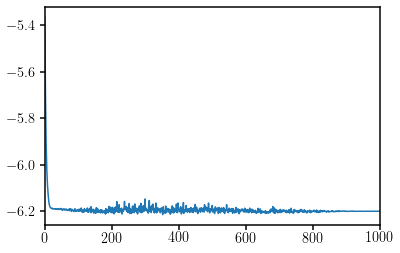

8.481919288635254 12.430063247680664
GMM with 83 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>999 	 -6.21301e+00
tensor([0.3661, 5.9354, 2.1292, 0.7397, 1.5327, 0.3944, 1.0085, 0.7551, 0.1551,
        0.3324, 0.9063, 0.3684, 0.5593, 7.5384, 0.6333, 0.7798, 0.6696, 0.3174,
        0.7041, 1.0529, 0.8048, 0.3027, 0.7122, 0.9798, 0.3659, 0.7234, 1.0459,
        0.3568, 0.9385, 2.6408, 0.7111, 1.1863, 0.3579, 1.3466, 0.9416, 0.1373,
        1.4431, 1.0445, 0.9110, 0.9649, 1.7322, 0.4288, 0.9744, 1.1846, 0.3035,
        0.3726, 0.7088, 0.9695, 1.0903, 0.3863, 7.2112, 6.0080, 2.1851, 8.6896,
        1.1774, 0.4493, 0.8067, 1.0815, 1.6125, 0.3454, 0.7819, 1.1660, 0.3395,
        0.6684, 0.6714, 0.1142, 2.3279, 3.9802, 0.9665, 1.1420, 1.2037, 1.5396,
        0.9469, 0.2952, 0.3660, 5.8032, 1.1756, 0.2102, 0.3360, 6.5251, 1.0417,
        1.1744, 0.0471], device='cuda:0', grad_fn=<ExpBackward0>)
Parameter containing:
tensor([10.2260, 10.2537, 10.2277, 10.9831, 10.2266, 10.2264, 10.9831, 10.9831,
        10.2957, 10.2255, 10.2253, 10.2261, 10.2330, 10.2348, 10.2256, 10.9831,
        10

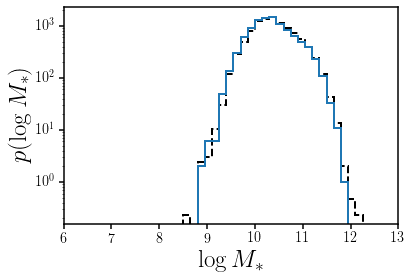

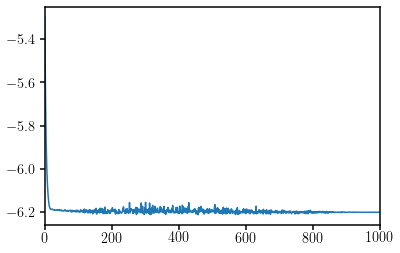

8.481919288635254 12.430063247680664
GMM with 33 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>999 	 -6.21144e+00
tensor([1.7628, 1.7047, 0.4487, 1.2118, 0.4494, 1.9447, 0.9386, 0.4460, 0.9374,
        0.8170, 1.1401, 1.2908, 2.2948, 0.5888, 0.6394, 2.2747, 0.5885, 0.4707,
        1.7312, 1.7247, 0.7007, 0.9074, 0.6302, 1.8209, 1.8140, 0.7966, 1.7792,
        0.5496, 0.6505, 0.4715, 0.6129, 1.2003, 1.7607], device='cuda:0',
       grad_fn=<ExpBackward0>)
Parameter containing:
tensor([10.2442, 10.2446, 10.2424, 10.3925, 10.2424, 10.2704, 10.8076, 10.2425,
        11.0108, 10.2389, 11.0108, 10.2407, 10.2628, 10.2396, 11.0108, 10.2636,
        10.2396, 10.2419, 10.2440, 10.2416, 10.2381, 11.0108, 11.0108, 10.2498,
        10.2495, 10.2384, 10.2469, 10.2402, 11.0108, 10.2418, 10.2390, 10.2353,
        10.2474], device='cuda:0', requires_grad=True)
tensor([0.3565, 0.3568, 0.3555, 0.0421, 0.3555, 0.3698, 0.1168, 0.3555, 0.2550,
        0.3532, 0.2550, 0.3544, 0.3663, 0.3537, 0.2550, 0.3667, 0.3537, 0.3551,
        0.3564, 0.3550, 0.3527, 0.2550, 0.2550, 0.3598, 0.3596, 0.3529, 0.35

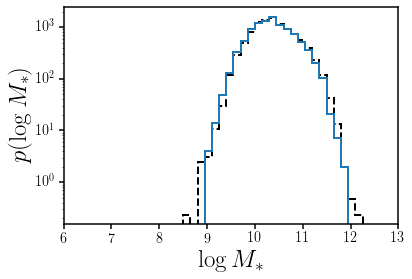

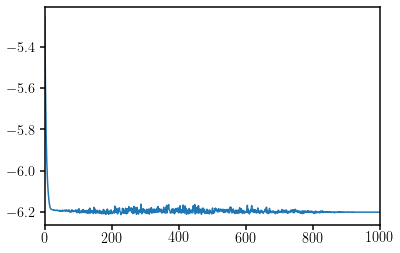

In [36]:
v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area # (Mpc/h)^3

w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) 
w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign'].data
print(w_import[zlim].min(), w_import[zlim].max())

x_data = torch.tensor(bgs['provabgs_logMstar'].data[zlim].astype(np.float32)).to(device)
w_data = torch.tensor(w_import[zlim].astype(np.float32)).to(device)

# make sure there aren't any Nans
assert torch.sum(np.isnan(x_data.cpu())) == 0 
assert torch.sum(np.isnan(w_data.cpu())) == 0

batch_size = 128
Ntrain = int(0.9 * x_data.shape[0])
Nvalid = x_data.shape[0] - Ntrain # int(0.1 * x_data.shape[0])

trainloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_data[:Ntrain], w_data[:Ntrain]),
        batch_size=batch_size,
        shuffle=True)

validloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_data[Ntrain:], w_data[Ntrain:]),
        batch_size=batch_size)

num_iter = 1000
#patience = 20
lr = 1e-2

best_flows, best_valid_losses, vls = [], [], []
for i in range(5): 
    ncomp = int(np.random.uniform(5, 100))
    flow = GaussianMixtureModel(n_components=ncomp, 
                                mmin=bgs['provabgs_logMstar'].data[zlim].min(), 
                                mmax=bgs['provabgs_logMstar'].data[zlim].max())

    print(bgs['provabgs_logMstar'].data[zlim].min(), bgs['provabgs_logMstar'].data[zlim].max())
    flow.to(device)
    print('GMM with %i components' % ncomp)


    best_epoch, best_valid_loss = 0., np.inf
    valid_losses = []
    optimizer = optim.Adam(flow.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, 
                                              epochs=num_iter, 
                                              steps_per_epoch=len(trainloader))
    t = trange(num_iter, leave=False)
    for epoch in t:
        train_loss = 0.
        for batch in trainloader: 
            optimizer.zero_grad()
            _post, _w = batch
            _post = _post.to(device)
            _w = _w.to(device)

            loss = Loss(flow, _post, _w)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            scheduler.step()

        train_loss /= len(trainloader.dataset)

        with torch.no_grad():
            valid_loss = 0.
            for batch in validloader: 
                _post, _w = batch
                _post = _post.to(device)
                _w = _w.to(device)

                loss = Loss(flow, _post, _w)                
                valid_loss += loss.item()
            valid_loss /= len(validloader.dataset)           
            valid_losses.append(valid_loss)

        t.set_description('Epoch: %i LR: %.2e TRAINING Loss: %.2e VALIDATION Loss: %.2e' % 
                          (epoch, scheduler.get_last_lr()[0], train_loss, valid_loss), refresh=False)
        if valid_loss < best_valid_loss: 
            best_valid_loss = valid_loss
            best_epoch = epoch
            best_flow = copy.deepcopy(flow)


    print('>>>%i \t %.5e' % (epoch, best_valid_loss))
    with torch.no_grad(): 
        post_prime = best_flow.sample((10000,))

    print(torch.exp(best_flow.logweights))
    print(best_flow.means)
    print(torch.exp(best_flow.logstdevs))

    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    _ = sub.hist(np.median(bgs['provabgs_logMstar'].data[zlim], axis=1), 
             weights=w_import[zlim]*10000./np.sum(w_import[zlim]), 
             range=(7., 13.), bins=40, histtype='step', 
             color='k', linestyle='--', linewidth=2)
    _ = sub.hist(np.array(post_prime.detach().cpu()), range=(7., 13.), bins=40, histtype='step', linewidth=2)
    sub.set_xlabel(r'$\log M_*$', fontsize=25)
    sub.set_xlim(6., 13.)
    sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
    sub.set_yscale('log')
    plt.show()

    plt.plot(np.arange(len(valid_losses)), valid_losses)
    plt.xlim(0, len(valid_losses))
    plt.show()

    best_flows.append(best_flow)
    best_valid_losses.append(best_valid_loss)
    vls.append(valid_losses)

37.326393


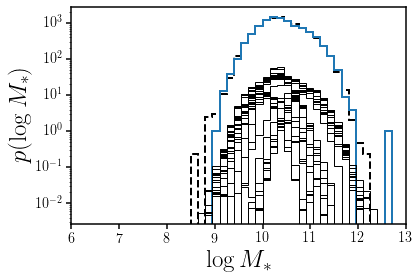

In [16]:
with torch.no_grad(): 
    post_prime = best_flow.sample((10000,))

fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)
_ = sub.hist(np.median(bgs['provabgs_logMstar'].data[zlim], axis=1), 
         weights=w_import[zlim]*10000./np.sum(w_import[zlim]), 
         range=(7., 13.), bins=40, histtype='step', 
         color='k', linestyle='--', linewidth=2)
_ = sub.hist(np.array(post_prime.detach().cpu()), range=(7., 13.), bins=40, histtype='step', linewidth=2)

for igmm in range(len(best_flow.means)): 
    _ = sub.hist(best_flow.means[igmm].cpu().detach().numpy() + 
                 np.exp(best_flow.logstdevs[igmm].cpu().detach().numpy()) * np.random.normal(size=10000), 
                 weights=np.repeat(np.exp(best_flow.logweights[igmm].cpu().detach().numpy()), 10000)/95, 
                 range=(7., 13.), bins=40, histtype='step', linewidth=1, color='k')
print(np.sum(np.exp(best_flow.cpu().logweights.detach().numpy())))
#         np.median(bgs['provabgs_logMstar'].data[zlim], axis=1), 
#          weights=w_import[zlim]*10000./np.sum(w_import[zlim]), 
#          range=(7., 13.), bins=40, histtype='step', 
#          color='k', linestyle='--', linewidth=2)

#                         print(torch.exp(best_flow.logweights))
#                         print(best_flow.means)
#                         print(torch.exp(best_flow.logstdevs))

sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(6., 13.)
sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
sub.set_yscale('log')
plt.show()

28564 galaxies
1.0 612.0132474339779
8.481919288635254 12.430063247680664
GMM with 13 components


/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>999 	 -6.20363e+00
tensor([0.9989, 0.7807, 0.4653, 1.2949, 1.2647, 1.9211, 1.4991, 1.0684, 1.2841,
        0.3834, 0.5288, 1.7963, 0.4945], device='cuda:0',
       grad_fn=<ExpBackward0>)
Parameter containing:
tensor([10.4531, 10.3355, 10.2266, 10.2229, 10.3877, 10.3296, 11.0708, 10.2250,
        10.2234, 10.2563, 10.2212, 10.3292, 10.2171], device='cuda:0',
       requires_grad=True)
tensor([0.4286, 0.1939, 0.3494, 0.3477, 0.4123, 0.3937, 0.2520, 0.3487, 0.3480,
        0.3634, 0.3470, 0.3935, 0.3451], device='cuda:0', dtype=torch.float64,
       grad_fn=<ExpBackward0>)


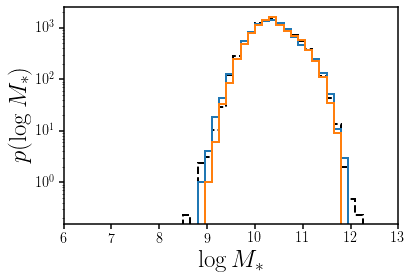

8.481919288635254 12.430063247680664
GMM with 52 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>999 	 -6.19844e+00
tensor([1.1931, 1.7008, 0.3743, 1.7239, 1.4171, 0.7166, 1.4106, 1.0567, 1.5173,
        0.5660, 0.5332, 0.4012, 1.5130, 0.6017, 0.4347, 0.4164, 1.7048, 0.8551,
        0.5467, 0.4391, 1.3598, 2.0448, 0.4421, 0.3631, 1.4033, 0.5592, 1.4501,
        0.4181, 0.7481, 0.5268, 1.5076, 1.4997, 0.5268, 0.9151, 1.5297, 1.4874,
        1.4911, 0.5232, 0.5697, 0.4524, 0.6700, 1.0945, 1.3897, 0.5121, 1.6686,
        1.6885, 0.5138, 1.5309, 1.4561, 0.5059, 1.5414, 0.8729],
       device='cuda:0', grad_fn=<ExpBackward0>)
Parameter containing:
tensor([10.4181, 10.5087, 10.2560, 10.5641, 10.2427, 10.9641, 10.4492, 10.9584,
        10.2025, 10.2082, 10.8924, 10.5337, 10.2488, 10.2216, 10.2271, 10.5475,
        10.9447, 10.9613, 10.2148, 10.2227, 10.1914, 10.3819, 10.2221, 10.2618,
        10.3567, 10.9227, 10.2105, 10.2360, 10.9629, 10.2041, 10.2453, 10.9632,
        10.2056, 10.2484, 10.2466, 10.2186, 10.2300, 10.1936, 10.2055, 10.5987,
        10.2135, 10.9600, 10.1912, 10.1981,

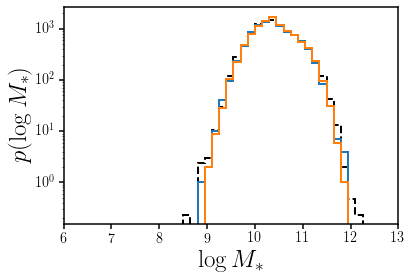

8.481919288635254 12.430063247680664
GMM with 44 components


  0%|          | 0/1000 [00:00<?, ?it/s]

>>>999 	 -6.20486e+00
tensor([0.6447, 1.5419, 0.5067, 1.0951, 0.4676, 1.6269, 2.0261, 0.4663, 1.4078,
        1.6696, 0.8639, 1.8086, 0.8281, 1.7363, 0.5656, 0.9383, 0.4663, 0.4595,
        0.9452, 2.3067, 1.9880, 0.8955, 1.3263, 1.3163, 2.0257, 0.4661, 0.9160,
        1.5820, 0.5483, 0.8581, 1.8415, 1.5933, 0.4599, 0.4887, 0.4655, 0.4599,
        0.7877, 2.3374, 1.6179, 0.5721, 0.4776, 1.0421, 1.6169, 1.6424],
       device='cuda:0', grad_fn=<ExpBackward0>)
Parameter containing:
tensor([11.0460, 10.2350, 10.2359, 10.2318, 10.2483, 10.2363, 10.2746, 10.2470,
        10.2416, 10.2390, 10.5223, 10.3958, 11.0471, 10.2441, 11.0599, 11.0523,
        10.6261, 10.5574, 11.0549, 10.3294, 10.3853, 11.0583, 10.2349, 10.3003,
        10.2767, 10.2477, 10.5606, 10.2424, 10.2245, 10.5819, 10.2523, 10.2352,
        10.5996, 10.9620, 10.2480, 10.6332, 10.5674, 10.3402, 10.2418, 10.2210,
        10.2455, 10.2292, 10.2413, 10.2408], device='cuda:0',
       requires_grad=True)
tensor([0.2337, 0.3438, 0.

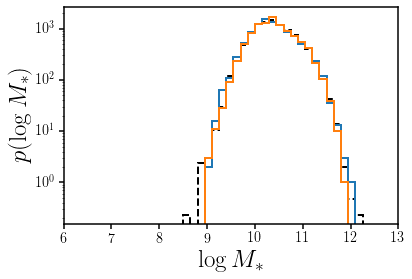

In [35]:
for zmin, zmax in zip(zmins[:1], zmaxs):
    # Vmax based importance weights
    zlim = (bgs['Z_HP'].data > zmin) & (bgs['Z_HP'].data < zmax) & (bgs['provabgs_w_zfail'].data > 0.)
    print('%i galaxies' % np.sum(zlim))
    
    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h**3 * f_area # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h**3 * f_area # (Mpc/h)^3
    
    w_import = (v_zmax - v_zmin) / (bgs['Vmax'].data.clip(v_zmin, v_zmax) - v_zmin) 
    w_import *= bgs['provabgs_w_zfail'].data * bgs['provabgs_w_fibassign']
    print(w_import[zlim].min(), w_import[zlim].max())

    x_data = torch.tensor(bgs['provabgs_logMstar'].data[zlim].astype(np.float32)).to(device)
    w_data = torch.tensor(w_import[zlim].astype(np.float32)).to(device)
    
    # make sure there aren't any Nans
    assert torch.sum(np.isnan(x_data.cpu())) == 0 
    assert torch.sum(np.isnan(w_data.cpu())) == 0
        
    batch_size = 128
    Ntrain = int(0.9 * x_data.shape[0])
    Nvalid = x_data.shape[0] - Ntrain # int(0.1 * x_data.shape[0])

    trainloader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(x_data[:Ntrain], w_data[:Ntrain]),
            batch_size=batch_size,
            shuffle=True)

    validloader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(x_data[Ntrain:], w_data[Ntrain:]),
            batch_size=batch_size)
    
    num_iter = 1000
    
    best_flows, best_valid_losses, vls = [], [], []
    for i in range(3): 
        ncomp = int(np.random.uniform(5, 100))
        flow = GaussianMixtureModel(n_components=ncomp, 
                                    mmin=bgs['provabgs_logMstar'].data[zlim].min(), 
                                    mmax=bgs['provabgs_logMstar'].data[zlim].max())
        
        print(bgs['provabgs_logMstar'].data[zlim].min(), bgs['provabgs_logMstar'].data[zlim].max())
        flow.to(device)
        print('GMM with %i components' % ncomp)

        
        best_valid_loss = np.inf
        valid_losses, lrs = [], []
        optimizer = optim.Adam(flow.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, min_lr=1e-4)
        
        best_epoch = 0 
        t = trange(num_iter, leave=False)
        for epoch in t:
            train_loss = 0.
            for batch in trainloader: 
                optimizer.zero_grad()
                _post, _w = batch
                _post = _post.to(device)
                _w = _w.to(device)

                loss = Loss(flow, _post, _w)
                loss.backward()
                train_loss += loss.item()
                optimizer.step()

            train_loss /= len(trainloader.dataset)

            with torch.no_grad():
                valid_loss = 0.
                for batch in validloader: 
                    _post, _w = batch
                    _post = _post.to(device)
                    _w = _w.to(device)

                    loss = Loss(flow, _post, _w)                
                    valid_loss += loss.item()
                valid_loss /= len(validloader.dataset)           
                valid_losses.append(valid_loss)

            scheduler.step(valid_loss)
            t.set_description('Epoch: %i LR %.2e TRAINING Loss: %.2e VALIDATION Loss: %.2e' % 
                              (epoch, scheduler._last_lr[0], train_loss, valid_loss), refresh=False)
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                best_epoch = epoch
                best_flow = copy.deepcopy(flow)
            
        print('>>>%i \t %.5e' % (epoch, best_valid_loss))
        print(torch.exp(best_flow.logweights))
        print(best_flow.means)
        print(torch.exp(best_flow.logstdevs))

        fig = plt.figure(figsize=(6,4))
        sub = fig.add_subplot(111)
        _ = sub.hist(np.median(bgs['provabgs_logMstar'].data[zlim], axis=1), 
                 weights=w_import[zlim]*10000./np.sum(w_import[zlim]), 
                 range=(7., 13.), bins=40, histtype='step', 
                 color='k', linestyle='--', linewidth=2)
        with torch.no_grad(): 
            post_prime = best_flow.sample((10000,))
        _ = sub.hist(np.array(post_prime.detach().cpu()), range=(7., 13.), bins=40, histtype='step', linewidth=2)
        with torch.no_grad(): 
            post_prime = flow.sample((10000,))
        _ = sub.hist(np.array(post_prime.detach().cpu()), range=(7., 13.), bins=40, histtype='step', linewidth=2)
        sub.set_xlabel(r'$\log M_*$', fontsize=25)
        sub.set_xlim(6., 13.)
        sub.set_ylabel(r'$p(\log M_*)$', fontsize=25)
        sub.set_yscale('log')
        plt.show()
        
        plt.plot(np.arange(len(valid_losses)), valid_losses)
        plt.xlim(0, len(valid_losses))
        plt.show()
                
        best_flows.append(best_flow)
        best_valid_losses.append(best_valid_loss)
        vls.append(valid_losses)